In [1]:
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from math import pi,sin,cos,acos,asin
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import math
from ml_metrics import rmse,mae
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from scipy.optimize import minimize

In [2]:
def cosd(b):
    return cos(math.radians(b))
def sind(a):
    return sin(math.radians(a))
def tand(f):
    return tan(math.radians(f))
def acosd(d):
    return math.degrees(acos(d))
def asind(c):
    return math.degrees(asin(c))

In [3]:
#variables: Ta, Ws, Wd, Qs

# IEEE method

#Ampacity-windspeed

In [4]:
Ts = 100 # maximum allowable Temp
def Re(Ta,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    return Do*p*Wv/u

In [5]:
def Qc(Ta,Wd,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*(10**(-6))*((Tf+273)**1.5))/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    q1= K*(1.01+1.35*(Re(Ta,Wv)**0.52))*kf*(Ts-Ta) #1.35 w/m correct at low wind speeds
    q2= K*0.754*(Re(Ta,Wv)**0.6)*kf*(Ts-Ta)  #0.754 w/m correct at high wind speeds
    # Choose the larger of (q1,q2)
    q3 = 3.645*(p**0.5)*(Do**0.75)*((Ts-Ta)**1.25) # 3.645 at low Wv use the larger of forced and natural
    
    if Wv <= 0.2:
        return q3
    else:
        return max(q1,q2)

In [6]:
def q1(Ta,Wd,Wv):
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    return K*(1.01+1.35*Re(Ta,Wv)**0.52)*kf*(Ts-Ta) #w/m correct at low wind speeds
    

In [7]:
def q2(Ta,Wd,Wv):
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    return K*0.754*Re(Ta,Wv)**0.6*kf*(Ts-Ta)  #w/m correct at high wind speeds

In [8]:
print(q1(25,90,5),q2(25,90,5))

316.97281688725127 361.10365090025203


In [9]:
Qc(25,90,5)

361.10365090025203

In [10]:
def Qr(Ta):
    Do=0.0309
    Ts=100
    e = 0.7# emissivity
    return 17.8*Do*e*(1/10**8)*((Ts+273)**4-(Ta+273)**4)

In [11]:
a = 0.9 # absorbsibility
Do = 0.0309 # Conductor diameter
def Qs(qs):
    return a*Do*qs

In [12]:
def R(Ta): 
    R_low = 0.0983/1609.344
    R_high = 0.117/1609.344
    T_low = 25
    T_high = 75
    Ts =100
    Tf =0.5*(Ts+Ta)
    return R_low + (R_high-R_low)*(Tf-T_low)/(T_high-T_low)+R_low

In [13]:
def I_3E(Ta,qs,Wv,Wd):
    return math.sqrt((Qc(Ta,Wd,Wv)+Qr(Ta)-Qs(qs))/R(Ta))


# CIGRE method


In [14]:
def Re_CI(Ta,Wv):
    Tf=0.5*(Ta+Ts)
    #Ts = 100 # maximum allowable Temp
    L=2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #lamda #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#muy #dynamic viscosity of air
    He = 10 # elevation
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#gamma#density of air
    return Do*g*Wv/m

In [15]:
Re_CI(40,0.61)

950.1315873023507

In [16]:
def Cf(Ta):
    Tf = 0.5*(Ts+Ta)
    M_s = 329*0.45359237/(1000*0.3048)
    M_a = 899*0.45359237/(1000*0.3048)
    M = 1228*0.45359237/(1000*0.3048)
    C_steel = 481*(1+10**(-4)*(Tf-20))
    C_alum = 897*(1+3.8*10**(-4)*(Tf-20))
    return (C_steel*M_s + C_alum*M_a)/M

In [17]:
roughness = 3.43/(2*(30.9-3.43))
print(roughness)

0.06243174372042228


In [18]:
Cf(25)

796.7002986156352

In [19]:
def Nu_90(Ta,Wv):
    if (Re_CI(Ta,Wv)>=100) and (Re_CI(Ta,Wv)<2650):
        return 0.641*Re_CI(Ta,Wv)**0.471
    elif (Re_CI(Ta,Wv)>=2650) and (Re_CI(Ta,Wv)<50000):
        return 0.048*Re_CI(Ta,Wv)**0.8
    else:
        return 0

In [20]:
#print(Re_CI(25,10),Re(25,10),Nu_90(25,0.4),Nu(25,0.4,90))

In [21]:
def Nu(Ta,Wv,Wd):
    if (Wd <=24):
        return Nu_90(Ta,Wv)*(0.42+0.68*(sind(Wd))**1.08)
    if (Wd >24):
        return Nu_90(Ta,Wv)*(0.42+0.58*(sind(Wd))**0.9)

def Nu_nat(Ta,Wv,Wd):
    Do = 0.0309
    Tf = 0.5*(Ta+Ts)
    L = 2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#dynamic viscosity of air
    He =10 # elevation
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#density of air     
    Gr = Do**3*(Ts-Ta)*10/((Tf+273)*(m/g))
    Pr = Cf(Tf)*m/L
    if ((Gr*Pr)>10**(-1))and((Gr*Pr)<10**2):
        return 1.02*(Gr*Pr)**0.148
    elif ((Gr*Pr)>10**(2))and((Gr*Pr)<10**4):
        return 0.850*(Gr*Pr)**0.188
    elif ((Gr*Pr)>10**(4))and((Gr*Pr)<10**7):
        return 0.480*(Gr*Pr)**0.250
    elif ((Gr*Pr)>10**(7))and((Gr*Pr)<10**12):
        return 0.125*(Gr*Pr)**0.333
    else:
        return 0

In [22]:
def Qc_CI(Ta,Wv,Wd):
    Do = 0.0309
    Tf = 0.5*(Ta+Ts)
    L = 2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#dynamic viscosity of air
    He =10 # elevation
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#density of air
    Pc_force = pi*L*(Ts-Ta)*Nu(Ta,Wv,Wd)
    Pc_nat = pi*L*(Ts-Ta)*Nu_nat(Ta,Wv,Wd)
    #if Wv <=0.5:
      #  return Pc_nat
    #else:
    return max(Pc_force,Pc_nat)

In [23]:
print(Qc_CI(40,0.61,90),Qc(40,90,0.61))

87.32660185833333 86.03478069105554


In [24]:
def I_CI(Ta,qs,Wv,Wd):
    return math.sqrt((Qc_CI(Ta,Wv,Wd)+Qr(Ta)-Qs(qs))/R(Ta))

In [25]:
Ta = np.array([1,2])
amp_plot_CI=np.array([I_CI(Ta[i], qs[i], Wv[i], Wd[i]) for i in range(len(Ta))])

NameError: name 'qs' is not defined

# LINEAMPS

In [26]:
def Re_LI(Ta,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    M_air = 1.103 #air density
    vf=(1.32*10**(-5)+Tf*9.5*10**(-8))*(1-He*(6.5*10**(-3)/288.16))**(-5.2561)
    # Wv = # wind velocity
    return M_air*Wv*Do/vf

In [27]:
def Nu_LI(Ta,Wv):
    return 0.64*Re_LI(Ta,Wv)**0.2+0.2*Re_LI(Ta,Wv)**0.61
print(Nu_LI(20,1))

22.226749118404168


In [28]:
def Qc_LI(Ta,Wv,Wd):
    Do = 0.0309
    Tf = 0.5*(Ta+Ts)
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    return K*kf*Nu_LI(Ta,Wv)*pi*(Ts-Ta)
    

In [29]:
Wd = np.linspace(0,90,5)
TEST = np.array([Qc_LI(25,5,Wdi) for Wdi in Wd])
print(TEST)

[145.8963584  250.99982369 321.4582666  351.33691156 376.02154226]


In [30]:
def I_LI(Ta,qs,Wv,Wd):
    return math.sqrt((Qc_LI(Ta,Wv,Wd)+Qr(Ta)-Qs(qs))/R(Ta))

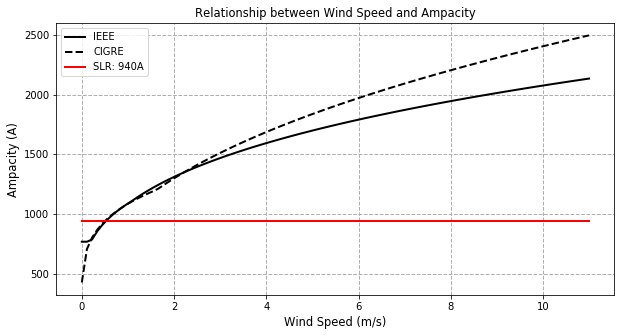

In [25]:
Wv = np.linspace(0,11,100)
fig = plt.figure(figsize=(10,5))
csfont = {'fontname':'Times New Roman'}
plt.plot(Wv,[I_3E(25,1000,Wvi,90) for Wvi in Wv],label='IEEE',color='black',linewidth=2)
plt.plot(Wv,[I_CI(25,1000,Wvi,90) for Wvi in Wv],label='CIGRE',color='black',linestyle='dashed',linewidth=2)
#plt.plot(Wv,[I_LI(25,1000,Wvi,90) for Wvi in Wv],label='LINEAMPS',color='black',linestyle='dashdot',linewidth=2)
#plt.plot(Wv,[I_LI(25,1000,Wvi,90) for Wvi in Wv],color='green',linewidth=3)
#ax.set_xticks(range(0,11,1))
#ax.set_xticklabels(range(0,11,1))
x = np.linspace(0,11,100)
y = [940 for i in x]
plt.plot(x,y,color='red',linewidth=2)
plt.plot(x,y,label='SLR: 940A',color='red',linewidth=2)
plt.legend(loc='upper left',ncol=1)
plt.title('Relationship between Wind Speed and Ampacity',fontsize=11.5)
plt.xlabel('Wind Speed (m/s)',fontsize=11.5)
plt.ylabel('Ampacity (A)',fontsize=11.5)
plt.grid(linestyle='dashed',linewidth=1)
plt.show()

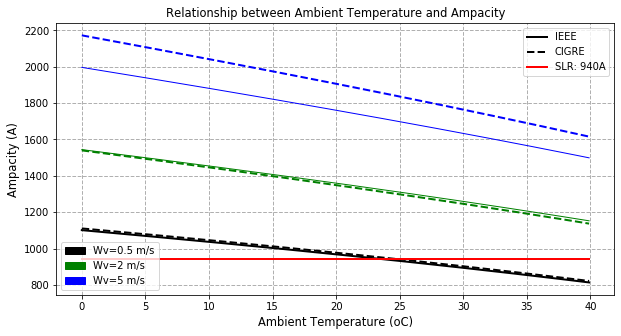

In [26]:
Ta = np.arange(0, 40, 0.3)
fig = plt.figure(figsize=(10,5))
#ax = plt.subplot()
#ax.set_yticks(range(0,2000,200))
#ax.set_yticklabels(range(0,2000,200))
#legend([a,b,c], ["legen1", "legend2","legend3"]
black = mpatches.Patch(color='black', label='Wv=0.5 m/s')
blue =mpatches.Patch(color='blue', label='Wv=5 m/s')
green = mpatches.Patch(color='green', label='Wv=2 m/s')
first_legend=plt.legend(handles=[black,green,blue],loc="lower left")
ax = plt.gca().add_artist(first_legend)
#Wv=0.5 m/s
plt.plot(Ta,[I_3E(Tai,1000,0.5,90) for Tai in Ta],label='IEEE',color='black',linewidth=2)
plt.plot(Ta,[I_CI(Tai,1000,0.5,90) for Tai in Ta],label='CIGRE',color='black',linestyle='dashed',linewidth=2)
#plt.plot(Ta,[I_LI(Tai,1000,0.5,90) for Tai in Ta],label='LINEAMPS',color='black',linestyle='dashdot',linewidth=2)
#Wv=2 m/s
plt.plot(Ta,[I_3E(Tai,1000,2,90) for Tai in Ta],color='green',linewidth=1)
plt.plot(Ta,[I_CI(Tai,1000,2,90) for Tai in Ta],color='green',linestyle='dashed',linewidth=2)
#plt.plot(Ta,[I_LI(Tai,1000,2,90) for Tai in Ta],color='green',linestyle='dashdot',linewidth=2)
#Wv=5 m/s
plt.plot(Ta,[I_3E(Tai,1000,5,90) for Tai in Ta],color='blue',linewidth=1)
plt.plot(Ta,[I_CI(Tai,1000,5,90) for Tai in Ta],color='blue',linestyle='dashed',linewidth=2)
#plt.plot(Ta,[I_LI(Tai,1000,5,90) for Tai in Ta],color='blue',linestyle='dashdot',linewidth=2)

x = np.arange(0, 40, 0.3)
y = [940 for i in x]
plt.plot(x,y,label='SLR: 940A',color='red',linewidth=2)
plt.legend(loc='upper right', bbox_to_anchor = (2,3),ncol=1)
plt.title('Relationship between Ambient Temperature and Ampacity',fontsize=11.5)
plt.xlabel('Ambient Temperature (oC)',fontsize=11.5)
plt.ylabel('Ampacity (A)',fontsize=11.5)
plt.legend()
plt.grid(linestyle='dashed',linewidth=1)
plt.show()

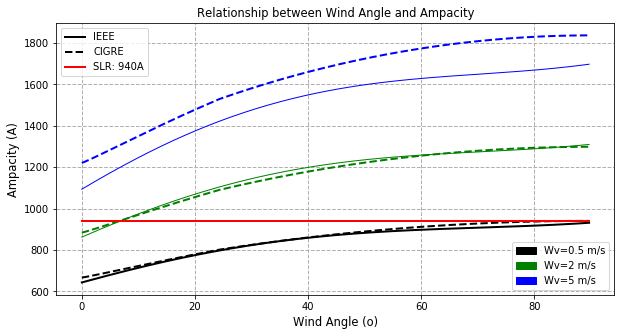

In [27]:
Wd = np.arange(0, 90, 0.3)
fig = plt.figure(figsize=(10,5))
#ax = plt.subplot()
#ax.set_yticks(range(0,2000,200))
#ax.set_yticklabels(range(0,2000,200))
#legend([a,b,c], ["legen1", "legend2","legend3"]
black = mpatches.Patch(color='black', label='Wv=0.5 m/s')
blue =mpatches.Patch(color='blue', label='Wv=5 m/s')
green = mpatches.Patch(color='green', label='Wv=2 m/s')
first_legend=plt.legend(handles=[black,green,blue],loc="lower right")
ax = plt.gca().add_artist(first_legend)
#Wv=0.5 m/s
plt.plot(Wd,[I_3E(25,1000,0.5,Wdi) for Wdi in Wd],label='IEEE',color='black',linewidth=2)
plt.plot(Wd,[I_CI(25,1000,0.5,Wdi) for Wdi in Wd],label='CIGRE',color='black',linestyle='dashed',linewidth=2)
#plt.plot(Wd,[I_LI(25,1000,0.5,Wdi) for Wdi in Wd],label='LINEAMPS',color='black',linestyle='dashdot',linewidth=2)
#Wv=2 m/s
plt.plot(Wd,[I_3E(25,1000,2,Wdi) for Wdi in Wd],color='green',linewidth=1)
plt.plot(Wd,[I_CI(25,1000,2,Wdi) for Wdi in Wd],color='green',linestyle='dashed',linewidth=2)
#plt.plot(Wd,[I_LI(25,1000,2,Wdi) for Wdi in Wd],color='green',linestyle='dashdot',linewidth=2)
#Wv=5 m/s
plt.plot(Wd,[I_3E(25,1000,5,Wdi) for Wdi in Wd],color='blue',linewidth=1)
plt.plot(Wd,[I_CI(25,1000,5,Wdi) for Wdi in Wd],color='blue',linestyle='dashed',linewidth=2)
#plt.plot(Wd,[I_LI(25,1000,5,Wdi) for Wdi in Wd],color='blue',linestyle='dashdot',linewidth=2)

x = np.arange(0, 90, 0.3)
y = [940 for i in x]
plt.plot(x,y,label='SLR: 940A',color='red',linewidth=2)
plt.legend(loc='upper right', bbox_to_anchor = (2,3),ncol=1)
plt.title('Relationship between Wind Angle and Ampacity',fontsize=11.5)
plt.xlabel('Wind Angle (o)',fontsize=11.5)
plt.ylabel('Ampacity (A)',fontsize=11.5)
plt.legend()
plt.grid(linestyle='dashed',linewidth=1)
plt.show()

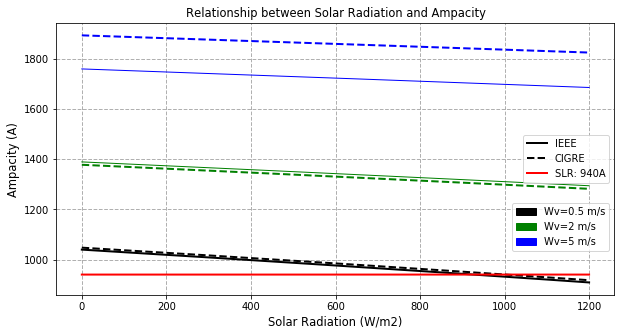

In [28]:
qs = np.arange(0, 1200, 0.3)
fig = plt.figure(figsize=(10,5))
#ax = plt.subplot()
#ax.set_yticks(range(0,2000,200))
#ax.set_yticklabels(range(0,2000,200))
#legend([a,b,c], ["legen1", "legend2","legend3"]
black = mpatches.Patch(color='black', label='Wv=0.5 m/s')
blue =mpatches.Patch(color='blue', label='Wv=5 m/s')
green = mpatches.Patch(color='green', label='Wv=2 m/s')
first_legend=plt.legend(handles=[black,green,blue],loc="best", bbox_to_anchor=(0.5, 0., 0.5, 0.5))
ax = plt.gca().add_artist(first_legend)
#Wv=0.5 m/s
plt.plot(qs,[I_3E(25,qsi,0.5,90) for qsi in qs],label='IEEE',color='black',linewidth=2)
plt.plot(qs,[I_CI(25,qsi,0.5,90) for qsi in qs],label='CIGRE',color='black',linestyle='dashed',linewidth=2)
#plt.plot(qs,[I_LI(25,qsi,0.5,90) for qsi in qs],label='LINEAMPS',color='black',linestyle='dashdot',linewidth=2)
#Wv=2 m/s
plt.plot(qs,[I_3E(25,qsi,2,90) for qsi in qs],color='green',linewidth=1)
plt.plot(qs,[I_CI(25,qsi,2,90) for qsi in qs],color='green',linestyle='dashed',linewidth=2)
#plt.plot(qs,[I_LI(25,qsi,2,90) for qsi in qs],color='green',linestyle='dashdot',linewidth=2)
#Wv=5 m/s
plt.plot(qs,[I_3E(25,qsi,5,90) for qsi in qs],color='blue',linewidth=1)
plt.plot(qs,[I_CI(25,qsi,5,90) for qsi in qs],color='blue',linestyle='dashed',linewidth=2)
#plt.plot(qs,[I_LI(25,qsi,5,90) for qsi in qs],color='blue',linestyle='dashdot',linewidth=2)

x = np.arange(0, 1200, 0.3)
y = [940 for i in x]
plt.plot(x,y,label='SLR: 940A',color='red',linewidth=2)
plt.legend(loc='lower right', bbox_to_anchor = (0.5,0.5))
plt.title('Relationship between Solar Radiation and Ampacity',fontsize=11.5)
plt.xlabel('Solar Radiation (W/m2)',fontsize=11.5)
plt.ylabel('Ampacity (A)',fontsize=11.5)
plt.legend()
plt.grid(linestyle='dashed',linewidth=1)
plt.show()

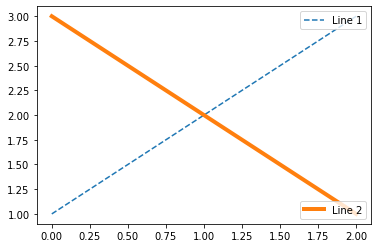

In [97]:
line1, = plt.plot([1, 2, 3], label="Line 1", linestyle='--')
line2, = plt.plot([3, 2, 1], label="Line 2", linewidth=4)

# Create a legend for the first line.
first_legend = plt.legend(handles=[line1], loc='upper right')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=[line2], loc='lower right')

plt.show()

In [63]:
print(I_3E(25,1000,0.5,90),I_CI(25,1000,0.5,90))

931.6872107866568 903.1339896665743


In [44]:
def C(w,X):
    if (((w<0)and(w<=-180))and(X>=0)):
        return 0
    if (((w>=0)and(w<180))and(X>=0)) or (((w<0)and(w<=-180))and(X<0)):
        return 180
    else:
        return 360

In [ ]:
Ks = 1+1.148*10**(-4)*He - 1.108*10**(-8)*He**(2)
Qse = Ks*Qs # solar heat intensity

In [ ]:
d = 23.46*sin((284+N)*360/365) # solar declination
lat = 21.028511
Hc = asind(cosd(lat)*cosd(d)*cosd(w)+sind(lat)*sind(d)) # altitude of the sun
X = sin(w)/(sind(lat)*cosd(w)-cos(lat)*tand(d)) # solar azimuth variable    
Zc = C + arctan(X) # azimuth of the sun
# A = # projected area of conductor
Qs = al*Qse*sind(theta)*A
theta = acosd(cosd(H)*cosd(Zc-Zl))

In [ ]:
    UT_Hour= float(datetime.strftime(UT_Time,'%H')) + float(datetime.strftime(UT_Time,'%M'))/60
    DOY = UT_Time.timetuple().tm_yday
    
    B= 2*pi*(DOY-81)/365
    ET= 9.87*sin(2*B)-7.53*cos(B)-1.5*sin(B)
    TSV=UT_Hour+5.7245/15+ET/60
    w=15*(TSV-12)*pi/180
    delta=pi/180*23.45*sin(B)

In [ ]:
def Qe(UT_time):
    UT_Hour= float(datetime.strftime(UT_Time,'%H')) + float(datetime.strftime(UT_Time,'%M'))/60
    DOY = UT_Time.timetuple().tm_yday

In [ ]:
clear_A = [-42.2391,63.8044,-1.922,3.46921*10**(-2),-3.61118*10**(-4),-4.07608*10**(-9)]
indus_A = [53.1821,14.211,6.6138*10**(-1),-3.1658*10**(-2),5.4654*10**(-4),-4.3446*10**(-6),1.3236**10**(-8)]
Qs_clear =  clear_A*[1, H,H**2,H**3,H**4,H**5,H**6]
Qs_indus = indus_A*[1, H,H**2,H**3,H**4,H**5,H**6]

In [ ]:
y=lambda x: 1-res.x[0]*(x/100)**(res.x[1])

x = np.array([i for i in range(0,101)])
plt.plot(x,y(x),color='red',linewidth=2)
ax.set_xticks(range(0,101,10))
ax.set_xticklabels(range(0,101,10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d%%'))